In [ ]:
import numpy as np
import tensorflow as tf
import copy
from keras.datasets import cifar10
from keras import datasets, layers, models, optimizers
from keras.layers import UpSampling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.utils import np_utils
from keras.models import load_model, Sequential
from tensorflow.keras.optimizers import SGD

# 1. Data Preparation

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


## Data normalization

In [ ]:
# Vectorize images
x_train_vec = x_train.reshape(x_train.shape[0], -1)
x_test_vec = x_test.reshape(x_test.shape[0], -1)

# Normalize vectorized images
mean = np.mean(x_train_vec, axis=0)
std = np.std(x_train_vec, axis=0)
x_train_norm = (x_train_vec - mean) / std

mean = np.mean(x_test_vec, axis=0)
std = np.std(x_test_vec, axis=0)
x_test_norm = (x_test_vec - mean) / std

# Normalize images CNN
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train_norm_cnn = (x_train - mean) / std

mean = np.mean(x_test, axis=0)
std = np.std(x_test, axis=0)
x_test_norm_cnn = (x_test - mean) / std

# Normalize images ResNet-50
x_train_rn = preprocess_input(x_train)
x_test_rn = preprocess_input(x_test)

# One-hot encoding
yt = y_train.reshape(y_train.shape[0])
y_train_oh = np.zeros((yt.size, yt.max()+1), dtype=float)
y_train_oh[np.arange(yt.size),yt] = 1

ytt = y_test.reshape(y_test.shape[0])
y_test_oh = np.zeros((ytt.size, ytt.max()+1), dtype=float)
y_test_oh[np.arange(ytt.size),ytt] = 1

# To categorical ResNet-50
y_train_rn = keras.utils.to_categorical(y_train)
y_test_rn = keras.utils.to_categorical(y_test)

# 2. Multilayer Perceptron Implementation
Multiclass classification multilayer perceptron <br>
D input features
<br>
C output classes
<br>
L hidden layers
<br>
M hidden units per layer

In [ ]:
def relu(x):
  return np.maximum(0, x)

def drelu(x):
  x[x<=0] = 0
  x[x>0] = 1
  return x

In [ ]:
def softmax(x):
  for i, row in enumerate(x):
    e_x = np.exp(row - np.max(row))
    x[i] = e_x / e_x.sum()
  return x

In [ ]:
class MLP:
  def __init__(self, activ_func=None, dactiv_func=None, L=0, M=0, add_bias=True):
    self.activ_func = activ_func
    self.dactiv_func = dactiv_func
    self.L = L
    self.M = M
    self.add_bias = add_bias
    self.train_hist = []
    self.test_hist = []
    pass

  def fit(self, x, y, optimizer):

    def gradient(x, y, weights):
      params = {}
      N,D = x.shape

      if self.add_bias:
        x = np.column_stack([x,np.ones(N)])

      # FORWARD PASS: get predicted y (i.e., yh) and value at each hidden layer
      # 0 hidden layers
      if self.L == 0:
        params['q1'] = np.dot(x, weights['w1'])
        params['yh'] = softmax(params['q1'])

      # 1 hidden layer
      if self.L == 1:
        params['q1'] = np.dot(x, weights['w1'])
        params['z1'] = self.activ_func(params['q1'])
        params['q2'] = np.dot(params['z1'], weights['w2'])
        params['yh'] = softmax(params['q2'])

      # 2 hidden layers
      if self.L == 2:
        params['q1'] = np.dot(x, weights['w1'])
        params['z1'] = self.activ_func(params['q1'])
        params['q2'] = np.dot(params['z1'], weights['w2'])
        params['z2'] = self.activ_func(params['q2'])
        params['q3'] = np.dot(params['z2'], weights['w3'])
        params['yh'] = softmax(params['q3'])


      # BACKWARD PASS: get all partial derivatives using hidden layer values and yh computed above
      dy = params['yh'] - y #N x C

      # Gradients for 0 hidden layers
      if self.L == 0:
        dw = np.dot(x.T, dy)/N #D
        dweights = {'w1':dw}
        return dweights

      # Gradients for 1 hidden layer
      if self.L == 1:
        dw2 = np.dot(params['z1'].T, dy)/N             # M x C

        dz1 = np.dot(dy, weights['w2'].T) * self.dactiv_func(params['q1'])           # N x M
        dw1 = np.dot(x.T, dz1)/N          # D x M

        dweights = {'w1':dw1, 'w2':dw2}
        return dweights

      # Gradient for 2 hidden layers
      elif self.L == 2:
        dw3 = np.dot(params['z2'].T, dy)/N             # M x C

        dz2 = np.dot(dy, weights['w3'].T) * self.dactiv_func(params['q2'])          # N x M
        dw2 = np.dot(params['z1'].T, dz2)/N   # M x M

        dz1 = np.dot(dz2, weights['w2'].T) * self.dactiv_func(params['q1'])        # N x M
        dw1 = np.dot(x.T, dz1)/N       # D x M

        dweights = {'w1': dw1, 'w2':dw2, 'w3':dw3}
        return dweights


    # Initialize weight values to random integers
    if self.add_bias:
      b = 1
    else:
      b = 0

    # 0 hidden layers
    if self.L == 0:
      weights0 = {'w1': np.random.randn(x.shape[1]+b, 10) * .01}         # D x C

    # 1 hidden layer
    elif self.L == 1:
      weights0 = {'w1': np.random.randn(x.shape[1]+b, self.M+b) * .01,   # D x M
                  'w2' : np.random.randn(self.M+b, 10) * .01}        # M x C

    # 2 hidden layers
    elif self.L == 2:
      weights0 = {'w1': np.random.randn(x.shape[1]+b, self.M+b) * .01,
                  'w2': np.random.randn(self.M+b, self.M+b) * .01,
                  'w3': np.random.randn(self.M+b, 10) * .01}


    # Run gradient descent
    self.params = optimizer.run(gradient, x, y, weights0)

    # Get training history accuracies
    for weights in optimizer.w_hist:
      yh_train = self.predict_w_weights(x_train_norm, weights)
      self.train_hist.append(evaluate_acc(yh_train, y_train))

      yh_test = self.predict_w_weights(x_test_norm, weights)
      self.test_hist.append(evaluate_acc(yh_test, y_test))

    return self


  def predict_w_weights(self, x, weights):
    if self.add_bias:
        x = np.column_stack([x,np.ones(x.shape[0])])

    # 0 hidden layers
    if self.L == 0:
      yh = softmax(np.dot(x, weights['w1']))

    # 1 hidden layer
    if self.L == 1:
      z1 = self.activ_func(np.dot(x, weights['w1']))
      yh = softmax(np.dot(z1, weights['w2']))

    # 2 hidden layers
    if self.L == 2:
      z1 = self.activ_func(np.dot(x, weights['w1']))
      z2 = self.activ_func(np.dot(z1, weights['w2']))
      yh = softmax(np.dot(z2, weights['w3']))

    return yh


  def predict(self, x):
    if self.add_bias:
        x = np.column_stack([x,np.ones(x.shape[0])])

    weights = self.params

    # 0 hidden layers
    if self.L == 0:
      yh = softmax(np.dot(x, weights['w1']))

    # 1 hidden layer
    if self.L == 1:
      z = self.activ_func(np.dot(x, weights['w1']))
      yh = softmax(np.dot(z, weights['w2']))

    # 2 hidden layers
    if self.L == 2:
      z1 = self.activ_func(np.dot(x, weights['w1']))
      z2 = self.activ_func(np.dot(z1, weights['w2']))
      yh = softmax(np.dot(z2, weights['w3']))
    return yh

In [ ]:
class GradientDescent:
  def __init__(self, learning_rate=0.01, epochs=20, epsilon=1e-8, batch_size=128):
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.epsilon = epsilon
    self.batch_size = batch_size
    self.w_hist = []

  def run(self, gradient_fn, x, y, ws):
    # Make mini batches
    x_batches = np.array_split(x, range(self.batch_size, len(x), self.batch_size))
    y_batches = np.array_split(y, range(self.batch_size, len(y), self.batch_size))

    norms = np.array([np.inf])
    e = 0
    w_hist = []
    # Run gradient descent
    while np.any(norms > self.epsilon) and e < (self.epochs):

      for i, x_batch in enumerate(x_batches):
        y_batch = y_batches[i]
        grad = gradient_fn(x_batch, y_batch, ws)

        # Weight update step
        for w, v in grad.items():
          ws[w] -= self.learning_rate * v

      norms = np.array([np.linalg.norm(g) for g in grad.values()])
      w_hist.append(copy.deepcopy(ws))
      e += 1

      #print('Done epoch', e)

    self.w_hist = w_hist

    return ws

In [ ]:
def confusion_matrix(y_pred, y_true):
  cmatrix = np.zeros([10,10])
  y_pred_labels = np.argmax(y_pred, axis=1)

  for i, pred in enumerate(y_pred_labels):
    true = y_true[i]
    cmatrix[pred, true] += 1
  return cmatrix

In [ ]:
def evaluate_acc(y_pred,y_true):
  cmatrix = confusion_matrix(y_pred, y_true)
  return np.trace(cmatrix) / np.sum(cmatrix)

# 3. Experiments

## 3.1 Analysing the effect of network depth and non-linearity <br>


1.   MLP with no hidden layers (L=0)
2.   MLP with one hidden layer (L=1), 256 units (M=256), and ReLu activation
3.   MLP with two hidden layers (L=2), 256 units (M=256), and ReLu activation



In [ ]:
# Create models
model_0 = MLP(add_bias=True)
model_1 = MLP(relu, drelu, L=1, M=256,add_bias=True)
model_2 = MLP(relu, drelu, L=2, M=256,add_bias=True)
optimizer0 = GradientDescent(learning_rate=.001, batch_size=256, epochs=50)
optimizer1 = GradientDescent(learning_rate=.01, batch_size=256, epochs=50)
optimizer2 = GradientDescent(learning_rate=.01, batch_size=256, epochs=50)

# Train models
fit_model_0 = model_0.fit(x_train_norm, y_train_oh, optimizer0)
fit_model_1 = model_1.fit(x_train_norm, y_train_oh, optimizer1)
fit_model_2 = model_2.fit(x_train_norm, y_train_oh, optimizer2)


In [ ]:
# Get accuracies
print('L=0 trainaccuracy:', fit_model_0.train_hist[-1])
print('L=0 test accuracy:', fit_model_0.test_hist[-1], '\n')

print('L=1 train accuracy:', fit_model_1.train_hist[-1])
print('L=1 test accuracy:', fit_model_1.test_hist[-1], '\n')

print('L=2 train accuracy:', fit_model_2.train_hist[-1])
print('L=2 test accuracy:', fit_model_2.test_hist[-1])

L=0 trainaccuracy: 0.43514
L=0 test accuracy: 0.4079 

L=1 train accuracy: 0.66624
L=1 test accuracy: 0.5373 

L=2 train accuracy: 0.6406
L=2 test accuracy: 0.534


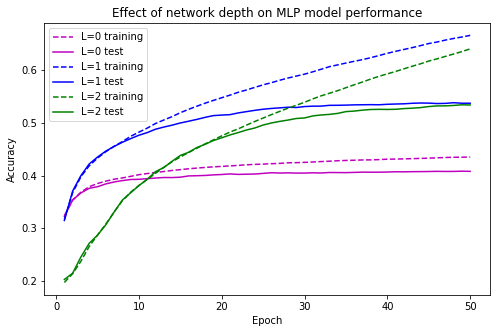

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(np.arange(1,51,1), fit_model_0.train_hist, 'm--', label='L=0 training')
plt.plot(np.arange(1,51,1), fit_model_0.test_hist, 'm-', label='L=0 test')

plt.plot(np.arange(1,51,1), fit_model_1.train_hist, 'b--', label='L=1 training')
plt.plot(np.arange(1,51,1), fit_model_1.test_hist, 'b-', label='L=1 test')

plt.plot(np.arange(1,51,1), fit_model_2.train_hist, 'g--', label='L=2 training')
plt.plot(np.arange(1,51,1), fit_model_2.test_hist, 'g-', label='L=2 test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of network depth on MLP model performance')
plt.legend()
plt.show()

## 3.2 Analysing changing activation function
Using model 3 from part 3.1 above, but changing the activation function to tanh and Leaky-ReLu.

In [ ]:
def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - np.tanh(x) ** 2

In [ ]:
def leaky_relu(x, alpha=0.01):
    return np.maximum(x, alpha*x)

def dleaky_relu(x, alpha=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

In [ ]:
#Create models
model_tanh = MLP(tanh, dtanh, L=2, M=256, add_bias=True)
model_lrelu = MLP(leaky_relu, dleaky_relu, L=2, M=256,add_bias=True)

optimizer_tanh = GradientDescent(learning_rate=.01, epochs=50, batch_size=256)
optimizer_lrelu = GradientDescent(learning_rate=.01, epochs=50, batch_size=256)

#Get predictions
fit_model_tanh = model_tanh.fit(x_train_norm, y_train_oh, optimizer_tanh)
fit_model_lrelu = model_lrelu.fit(x_train_norm, y_train_oh, optimizer_lrelu)

tanh model accuracy: 0.4757
leaky ReLU model accuracy: 0.5351


In [ ]:
# Get accuracies
print('tanh model train accuracy:', fit_model_tanh.train_hist[-1])
print('tanh model test accuracy:', fit_model_tanh.test_hist[-1], '\n')

print('leaky ReLU train model accuracy:', fit_model_lrelu.train_hist[-1])
print('leaky ReLU train model accuracy:', fit_model_lrelu.test_hist[-1])

tanh model train accuracy: 0.5592
tanh model test accuracy: 0.4757 

leaky ReLU train model accuracy: 0.63668
leaky ReLU train model accuracy: 0.5351


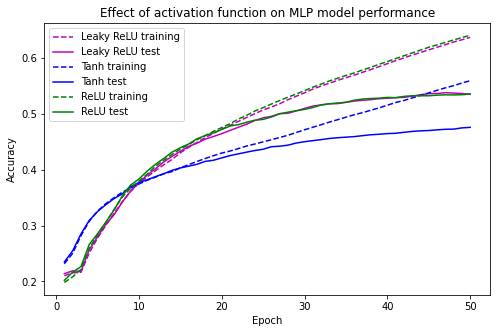

In [ ]:
# Plot accuracies as a function of epoch number
plt.figure(figsize=(8,5))

plt.plot(np.arange(1,51,1), fit_model_lrelu.train_hist, 'm--', label='Leaky ReLU training')
plt.plot(np.arange(1,51,1), fit_model_lrelu.test_hist, 'm-', label='Leaky ReLU test')

plt.plot(np.arange(1,51,1), fit_model_tanh.train_hist, 'b--', label='Tanh training')
plt.plot(np.arange(1,51,1), fit_model_tanh.test_hist, 'b-', label='Tanh test')

plt.plot(np.arange(1,51,1), fit_model_2.train_hist, 'g--', label='ReLU training')
plt.plot(np.arange(1,51,1), fit_model_2.test_hist, 'g-', label='ReLU test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of activation function on MLP model performance')
plt.legend()
plt.show()

## 3.3 Adding regularization
L1 and L2 regularization is added to a model with 2 hidden layers, 256 units, and ReLu activation.

In [ ]:
class MLP_L1_L2:
  def __init__(self, activ_func=None, dactiv_func=None, L=0, M=0, add_bias=True, l1_reg=False, l2_reg=False, reg_alpha=0.001, reg_lambda=0.001):
    self.activ_func = activ_func
    self.dactiv_func = dactiv_func
    self.L = L
    self.M = M
    self.add_bias = add_bias
    self.train_hist = []
    self.test_hist = []
    self.reg_alpha = reg_alpha
    self.reg_lambda = reg_lambda
    self.l1_reg = l1_reg
    self.l2_reg = l2_reg
    pass

  def fit(self, x, y, optimizer):

    def gradient(x, y, weights):
      params = {}
      N,D = x.shape

      if self.add_bias:
        x = np.column_stack([x,np.ones(N)])

      # FORWARD PASS: get predicted y (i.e., yh) and value at each hidden layer
      # 0 hidden layers
      if self.L == 0:
        params['q1'] = np.dot(x, weights['w1'])
        params['yh'] = softmax(params['q1'])

      # 1 hidden layer
      if self.L == 1:
        params['q1'] = np.dot(x, weights['w1'])
        params['z1'] = self.activ_func(params['q1'])
        params['q2'] = np.dot(params['z1'], weights['w2'])
        params['yh'] = softmax(params['q2'])

      # 2 hidden layers
      if self.L == 2:
        params['q1'] = np.dot(x, weights['w1'])
        params['z1'] = self.activ_func(params['q1'])
        params['q2'] = np.dot(params['z1'], weights['w2'])
        params['z2'] = self.activ_func(params['q2'])
        params['q3'] = np.dot(params['z2'], weights['w3'])
        params['yh'] = softmax(params['q3'])


      # BACKWARD PASS: get all partial derivatives using hidden layer values and yh computed above
      dy = params['yh'] - y #N x C

      # Gradients for 0 hidden layers
      if self.L == 0:
        dw = np.dot(x.T, dy)/N #D
        dweights = {'w1':dw}
        return dweights

      # Gradients for 1 hidden layer
      if self.L == 1:
        dw2 = np.dot(params['z1'].T, dy)/N             # M x C

        dz1 = np.dot(dy, weights['w2'].T) * self.dactiv_func(params['q1'])           # N x M
        dw1 = np.dot(x.T, dz1)/N          # D x M

        if self.l1_reg:
            dw1 += self.reg_alpha * np.sign(weights['w1'])
            dw2 += self.reg_alpha * np.sign(weights['w2'])
        if self.l2_reg:
            dw1 += self.reg_lambda * weights['w1']
            dw2 += self.reg_lambda * weights['w2']

        dweights = {'w1':dw1, 'w2':dw2}
        return dweights

      # Gradient for 2 hidden layers
      elif self.L == 2:
        dw3 = np.dot(params['z2'].T, dy)/N             # M x C

        dz2 = np.dot(dy, weights['w3'].T) * self.dactiv_func(params['q2'])          # N x M
        dw2 = np.dot(params['z1'].T, dz2)/N   # M x M

        dz1 = np.dot(dz2, weights['w2'].T) * self.dactiv_func(params['q1'])        # N x M
        dw1 = np.dot(x.T, dz1)/N       # D x M

        # Apply regularization to the weight update
        if self.l1_reg:
          dw1 += self.reg_alpha * np.sign(dw1)
          dw2 += self.reg_alpha * np.sign(dw2)
          dw3 += self.reg_alpha * np.sign(dw3)
        if self.l2_reg:
          dw1 += self.reg_lambda * dw1
          dw2 += self.reg_lambda * dw2
          dw3 += self.reg_lambda * dw3


        dweights = {'w1': dw1, 'w2':dw2, 'w3':dw3}
        return dweights


    # Initialize weight values to random integers
    if self.add_bias:
      b = 1
    else:
      b = 0

    # 0 hidden layers
    if self.L == 0:
      weights0 = {'w1': np.random.randn(x.shape[1]+b, 10) * .01}         # D x C

    # 1 hidden layer
    elif self.L == 1:
      weights0 = {'w1': np.random.randn(x.shape[1]+b, self.M+b) * .01,   # D x M
                  'w2' : np.random.randn(self.M+b, 10) * .01}        # M x C

    # 2 hidden layers
    elif self.L == 2:
      weights0 = {'w1': np.random.randn(x.shape[1]+b, self.M+b) * .01,
                  'w2': np.random.randn(self.M+b, self.M+b) * .01,
                  'w3': np.random.randn(self.M+b, 10) * .01}


    # Run gradient descent
    self.params = optimizer.run(gradient, x, y, weights0)

    # Get training history accuracies
    for weights in optimizer.w_hist:
      yh_train = self.predict_w_weights(x_train_norm, weights)
      self.train_hist.append(evaluate_acc(yh_train, y_train))

      yh_test = self.predict_w_weights(x_test_norm, weights)
      self.test_hist.append(evaluate_acc(yh_test, y_test))

    return self


  def predict_w_weights(self, x, weights):
    if self.add_bias:
        x = np.column_stack([x,np.ones(x.shape[0])])

    # 0 hidden layers
    if self.L == 0:
      yh = softmax(np.dot(x, weights['w1']))

    # 1 hidden layer
    if self.L == 1:
      z1 = self.activ_func(np.dot(x, weights['w1']))
      yh = softmax(np.dot(z1, weights['w2']))

    # 2 hidden layers
    if self.L == 2:
      z1 = self.activ_func(np.dot(x, weights['w1']))
      z2 = self.activ_func(np.dot(z1, weights['w2']))
      yh = softmax(np.dot(z2, weights['w3']))

    return yh


  def predict(self, x):
    if self.add_bias:
        x = np.column_stack([x,np.ones(x.shape[0])])

    weights = self.params

    # 0 hidden layers
    if self.L == 0:
      yh = softmax(np.dot(x, weights['w1']))

    # 1 hidden layer
    if self.L == 1:
      z = self.activ_func(np.dot(x, weights['w1']))
      yh = softmax(np.dot(z, weights['w2']))

    # 2 hidden layers
    if self.L == 2:
      z1 = self.activ_func(np.dot(x, weights['w1']))
      z2 = self.activ_func(np.dot(z1, weights['w2']))
      yh = softmax(np.dot(z2, weights['w3']))
    return yh

In [ ]:
#Create model
model_l1 = MLP_L1_L2(relu, drelu, L=2, M=256, add_bias=True,l1_reg=True)
model_l2 = MLP_L1_L2(relu, drelu, L=2, M=256, add_bias=True,l2_reg=True)

optimizerl1 = GradientDescent(learning_rate=.01, epochs=50, batch_size=256)
optimizerl2 = GradientDescent(learning_rate=.01, epochs=50, batch_size=256)

#Get predictions
fit_model_l1 = model_l1.fit(x_train_norm, y_train_oh, optimizerl1)
fit_model_l2 = model_l2.fit(x_train_norm, y_train_oh, optimizerl2)


In [ ]:
# Get accuracies
print('L1 model train accuracy:', model_l1.train_hist[-1])
print('L1 model test accuracy:', model_l1.test_hist[-1], '\n')

print('L2 model train accuracy:', model_l2.train_hist[-1])
print('L2 model test accuracy:', model_l2.test_hist[-1])

L1 model train accuracy: 0.68432
L1 model test accuracy: 0.5369 

L2 model train accuracy: 0.64226
L2 model test accuracy: 0.5379


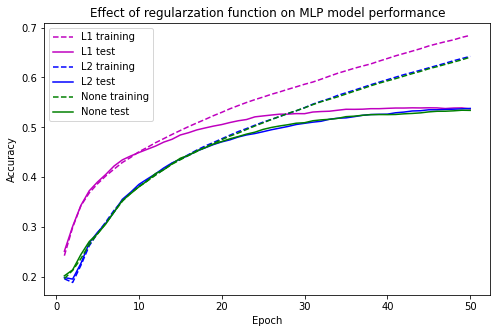

In [ ]:
# Plot accuracies as a function of epoch number
plt.figure(figsize=(8,5))

plt.plot(np.arange(1,51,1), model_l1.train_hist, 'm--', label='L1 training')
plt.plot(np.arange(1,51,1), model_l1.test_hist, 'm-', label='L1 test')

plt.plot(np.arange(1,51,1), model_l2.train_hist, 'b--', label='L2 training')
plt.plot(np.arange(1,51,1), model_l2.test_hist, 'b-', label='L2 test')

plt.plot(np.arange(1,51,1), fit_model_2.train_hist, 'g--', label='None training')
plt.plot(np.arange(1,51,1), fit_model_2.test_hist, 'g-', label='None test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of regularzation function on MLP model performance')
plt.legend()
plt.show()

## 3.4 Training on unnormalized images
Unnormalized images used to train a model with 2 hidden layers, 256 units, and ReLu activations.

In [ ]:
#Create model
model_unnorm = MLP(relu, drelu, L=2, M=256,add_bias=True)
optimizer_unnorm = GradientDescent(learning_rate=.01, batch_size=256, epochs=50)

#Get predictions
# Be sure to change predictions in MLP class such that they predict on x_train_unnorm and x_test_unnorm
x_train_unnorm = np.reshape(x_train, (50000, 3072))
x_test_unnorm = np.reshape(x_test, (10000, 3072))
fit_model_unnorm = model_unnorm.fit(x_train_unnorm, y_train_oh, optimizer_unnorm)

In [ ]:
# Get Accuracies
print('Un-normalized model train accuracy:', fit_model_unnorm.train_hist[-1])
print('Un-normalized model test accuracy:', fit_model_unnorm.test_hist[-1])

Un-normalized model train accuracy: 0.40004
Un-normalized model test accuracy: 0.3957


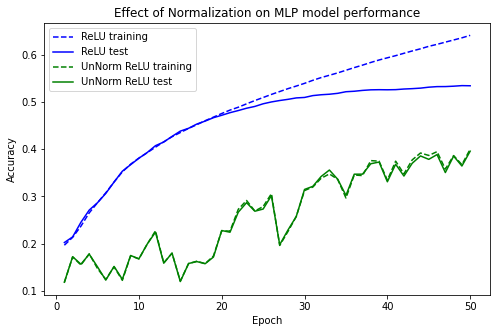

In [ ]:
# Plot accuracies as a function of epoch number
plt.figure(figsize=(8,5))

plt.plot(np.arange(1,51,1), fit_model_2.train_hist, 'b--', label='ReLU training')
plt.plot(np.arange(1,51,1), fit_model_2.test_hist, 'b-', label='ReLU test')

plt.plot(np.arange(1,51,1), fit_model_unnorm.train_hist, 'g--', label='UnNorm ReLU training')
plt.plot(np.arange(1,51,1), fit_model_unnorm.test_hist, 'g-', label='UnNorm ReLU test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of Normalization on MLP model performance')
plt.legend()
plt.show()

## 3.5 Comparison with convolutional neural networks
CNN with 2 convolutional and 2 fully connected layers. 256 units in the fully connected layers. ReLu activation for all layers.

In [ ]:
CNN_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile model
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
CNN_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = CNN_model.fit(x_train_norm_cnn, y_train_oh, epochs=20, validation_data = (x_test_norm_cnn, y_test_oh), batch_size = 32)

# Evaluate model on test set
test_loss, test_acc = CNN_model.evaluate(x_test_norm_cnn, y_test_oh, verbose=2)
print('Test accuracy:', test_acc)

# Plot accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('CNN Model accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0,20,2))
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('CNN Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 3.6 Pre-trained ResNet50 CNN
All fully connected layers of a pre-trained model are removed. 3 fully connected layers are added right after the convolutional layers. These fully connected layers are then trained on the CIFAR-10 dataset.

In [ ]:
base_model = ResNet50(weights = 'imagenet', include_top = False, pooling ='max', classes = 10)

#Freeze all convolutional layers
for layer in base_model.layers:
  layer.trainable = False

RN50_model = Sequential()
RN50_model.add(UpSampling2D())
RN50_model.add(UpSampling2D ())
RN50_model.add (UpSampling2D ())
RN50_model.add(base_model)

#Remove fully connected layers
RN50_model.add(Flatten())

#Adding a number of fully connected layers
RN50_model.add(BatchNormalization())
RN50_model.add (Dense (128, activation='relu' ))
RN50_model.add(Dropout (0.2))
RN50_model.add(BatchNormalization())
RN50_model.add(Dense (64, activation= 'relu'))
RN50_model.add(Dropout (0.2))
RN50_model.add(BatchNormalization())
RN50_model.add(Dense (10, activation = 'softmax'))

RN50_model.compile(optimizer = SGD(learning_rate = 0.1), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = RN50_model.fit(x = x_train_rn, y = y_train_rn, epochs = 20, batch_size = 128, validation_data=(x_test_rn, y_test_rn))

test_loss, test_acc = RN50_model.evaluate(x_test_rn, y_test_rn, verbose=2)
print('Test accuracy:', test_acc)

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('ResNet-50 Model Performance on CIFAR-10 Dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/20
 41/391 [==>...........................] - ETA: 3:18:56 - loss: 1.4810 - accuracy: 0.4962

KeyboardInterrupt: ignored

## 3.7 Analysing the effect of model width

In [ ]:
#Create models
model_128 = MLP(relu, drelu, L=2, M=128, add_bias=True)
model_64 = MLP(relu, drelu, L=2, M=64,add_bias=True)

optimizer_128 = GradientDescent(learning_rate=.01, epochs=50, batch_size=256)
optimizer_64 = GradientDescent(learning_rate=.01, epochs=50, batch_size=256)

#Get predictions
fit_model_128 = model_128.fit(x_train_norm, y_train_oh, optimizer_128)
fit_model_64 = model_64.fit(x_train_norm, y_train_oh, optimizer_64)

In [ ]:
# Get accuracies
print('64 hidden unit model train accuracy:', fit_model_64.train_hist[-1])
print('64 hidden unit model test accuracy:', fit_model_64.test_hist[-1], '\n')

print('128 hidden unit model train accuracy:', fit_model_128.train_hist[-1])
print('128 hidden unit model test accuracy:', fit_model_128.test_hist[-1])

64 hidden unit model train accuracy: 0.5495
64 hidden unit model test accuracy: 0.4979 

128 hidden unit model train accuracy: 0.59314
128 hidden unit model test accuracy: 0.5213


NameError: ignored

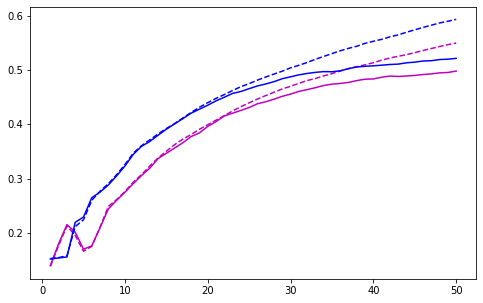

In [ ]:
# Plot accuracies as a function of epoch number
plt.figure(figsize=(8,5))

plt.plot(np.arange(1,51,1), fit_model_64.train_hist, 'm--', label='M=64 training')
plt.plot(np.arange(1,51,1), fit_model_64.test_hist, 'm-', label='M=64 test')

plt.plot(np.arange(1,51,1), fit_model_128.train_hist, 'b--', label='M=128 training')
plt.plot(np.arange(1,51,1), fit_model_128.test_hist, 'b-', label='M=128 test')

plt.plot(np.arange(1,51,1), fit_model_2.train_hist, 'g--', label='M=256 training')
plt.plot(np.arange(1,51,1), fit_model_2.test_hist, 'g-', label='M=256 test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of network width on MLP model performance')
plt.legend()
plt.show()

# Appendix

## 3.1 Hyperparameter tuning

In [ ]:
# Select best learning rate
learning_rates = [0.0001, 0.001, 0.01, 0.1]

model_0_lr_train_accs = []
model_0_lr_test_accs = []

model_1_lr_train_accs = []
model_1_lr_test_accs = []

model_2_lr_train_accs = []
model_2_lr_test_accs = []


for lr in learning_rates:

  # No hidden layers
  optimizer_0 = GradientDescent(learning_rate=lr, epochs=50, batch_size=128)
  model_0 = MLP(L=0, M=0, add_bias=True)
  fit_model_0 = model_0.fit(x_train_norm, y_train_oh, optimizer_0)

  model_0_lr_train_accs.append(fit_model_0.train_hist)
  model_0_lr_test_accs.append(fit_model_0.test_hist)

  # 1 hidden layer
  optimizer_1 = GradientDescent(learning_rate=lr, epochs=50, batch_size=128)
  model_1 = MLP(relu, drelu, L=1, M=256, add_bias=True)
  fit_model_1 = model_1.fit(x_train_norm, y_train_oh, optimizer_1)

  model_1_lr_train_accs.append(fit_model_1.train_hist)
  model_1_lr_test_accs.append(fit_model_1.test_hist)

  # 2 hidden layers
  optimizer_2 = GradientDescent(learning_rate=lr, epochs=50, batch_size=128)
  model_2 = MLP(relu, drelu, L=2, M=256, add_bias=True)
  fit_model_2 = model_2.fit(x_train_norm, y_train_oh, optimizer_2)

  model_2_lr_train_accs.append(fit_model_2.train_hist)
  model_2_lr_test_accs.append(fit_model_2.test_hist)

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,51,1), model_0_lr_test_accs[0], 'r-', label='lr=0.0001')
plt.plot(np.arange(1,51,1), model_0_lr_test_accs[1], 'm-', label='lr=0.001')
plt.plot(np.arange(1,51,1), model_0_lr_test_accs[2], 'b-', label='lr=0.01')
plt.plot(np.arange(1,51,1), model_0_lr_test_accs[3], 'g-', label='lr=0.1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of learning rate on 0-layer MLP model performance')
plt.show()

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,51,1), model_1_lr_test_accs[0], 'r-', label='lr=0.0001')
plt.plot(np.arange(1,51,1), model_1_lr_test_accs[1], 'm-', label='lr=0.001')
plt.plot(np.arange(1,51,1), model_1_lr_test_accs[2], 'b-', label='lr=0.01')
plt.plot(np.arange(1,51,1), model_1_lr_test_accs[3], 'g-', label='lr=0.1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of learning rate on 1-layer MLP model performance')
plt.show()

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,51,1), model_2_lr_test_accs[0], 'r-', label='lr=0.0001')
plt.plot(np.arange(1,51,1), model_2_lr_test_accs[1], 'm-', label='lr=0.001')
plt.plot(np.arange(1,51,1), model_2_lr_test_accs[2], 'b-', label='lr=0.01')
plt.plot(np.arange(1,51,1), model_2_lr_test_accs[3], 'g-', label='lr=0.1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of learning rate on 2-layer MLP model performance')
plt.show()

In [ ]:
# Select best batch size
batch_sizes =  [64,128,256]

model_0_bs_train_accs = []
model_0_bs_test_accs = []

model_1_bs_train_accs = []
model_1_bs_test_accs = []

model_2_bs_train_accs = []
model_2_bs_test_accs = []


for bs in batch_sizes:

  # No hidden layers
  optimizer_0 = GradientDescent(learning_rate=0.001, epochs=50, batch_size=bs)
  model_0 = MLP(L=0, M=0, add_bias=True)
  fit_model_0 = model_0.fit(x_train_norm, y_train_oh, optimizer_0)

  model_0_bs_train_accs.append(fit_model_0.train_hist)
  model_0_bs_test_accs.append(fit_model_0.test_hist)


  # 1 hidden layer
  optimizer_1 = GradientDescent(learning_rate=0.01, epochs=50, batch_size=bs)
  model_1 = MLP(relu, drelu, L=1, M=256, add_bias=True)
  fit_model_1 = model_1.fit(x_train_norm, y_train_oh, optimizer_1)

  model_1_bs_train_accs.append(fit_model_1.train_hist)
  model_1_bs_test_accs.append(fit_model_1.test_hist)

  # 2 hidden layers
  optimizer_2 = GradientDescent(learning_rate=0.01, epochs=50, batch_size=bs)
  model_2 = MLP(relu, drelu, L=2, M=256, add_bias=True)
  fit_model_2 = model_2.fit(x_train_norm, y_train_oh, optimizer_2)

  model_2_bs_train_accs.append(fit_model_2.train_hist)
  model_2_bs_test_accs.append(fit_model_2.test_hist)

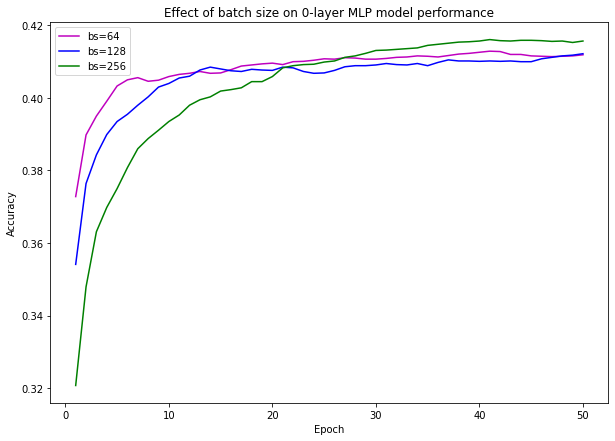

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,51,1), model_0_bs_test_accs[0], 'm-', label='bs=64')
plt.plot(np.arange(1,51,1), model_0_bs_test_accs[1], 'b-', label='bs=128')
plt.plot(np.arange(1,51,1), model_0_bs_test_accs[2], 'g-', label='bs=256')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of batch size on 0-layer MLP model performance')
plt.show()

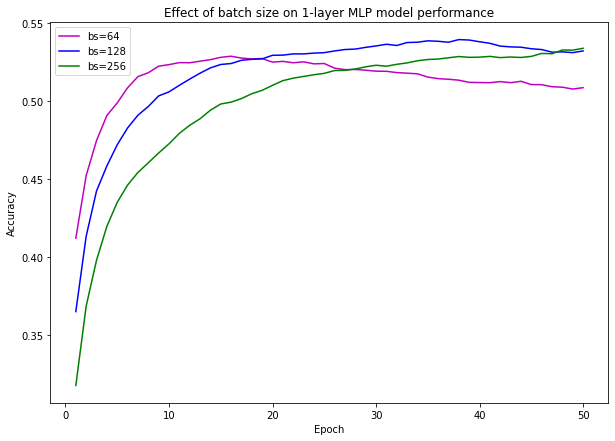

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,51,1), model_1_bs_test_accs[0], 'm-', label='bs=64')
plt.plot(np.arange(1,51,1), model_1_bs_test_accs[1], 'b-', label='bs=128')
plt.plot(np.arange(1,51,1), model_1_bs_test_accs[2], 'g-', label='bs=256')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of batch size on 1-layer MLP model performance')
plt.show()

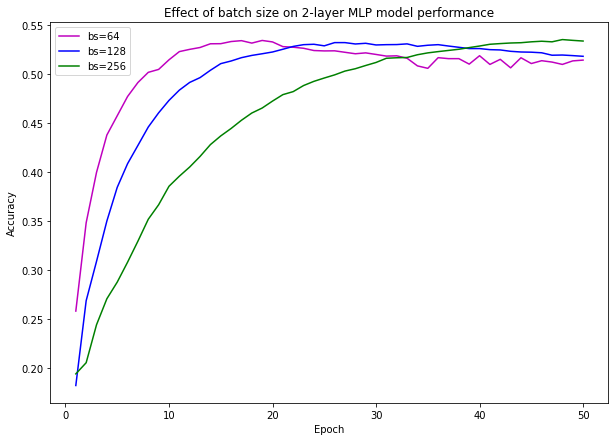

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,51,1), model_2_bs_test_accs[0], 'm-', label='bs=64')
plt.plot(np.arange(1,51,1), model_2_bs_test_accs[1], 'b-', label='bs=128')
plt.plot(np.arange(1,51,1), model_2_bs_test_accs[2], 'g-', label='bs=256')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of batch size on 2-layer MLP model performance')
plt.show()

## 3.2 Hyperparameter tuning

In [ ]:
# Select best learning rate
learning_rates = [0.0001, 0.001, 0.01, 0.1]

model_tanh_lr_train_accs = []
model_tanh_lr_test_accs = []

model_lrelu_lr_train_accs = []
model_lrelu_lr_test_accs = []

for lr in learning_rates:
  # tanh
  optimizer_tanh = GradientDescent(learning_rate=lr, epochs=50, batch_size=128)
  model_tanh = MLP(tanh, dtanh, L=2, M=256, add_bias=True)
  fit_model_tanh = model_tanh.fit(x_train_norm, y_train_oh, optimizer_tanh)

  model_tanh_lr_train_accs.append(fit_model_tanh.train_hist)
  model_tanh_lr_test_accs.append(fit_model_tanh.test_hist)

  # Leaky ReLU
  optimizer_lrelu = GradientDescent(learning_rate=lr, epochs=50, batch_size=128)
  model_lrelu = MLP(leaky_relu, dleaky_relu, L=2, M=256, add_bias=True)
  fit_model_lrelu = model_lrelu.fit(x_train_norm, y_train_oh, optimizer_lrelu)

  model_lrelu_lr_train_accs.append(fit_model_lrelu.train_hist)
  model_lrelu_lr_test_accs.append(fit_model_lrelu.test_hist)

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,51,1), model_tanh_lr_test_accs[0], 'r-', label='lr=0.0001')
plt.plot(np.arange(1,51,1), model_tanh_lr_test_accs[1], 'm-', label='lr=0.001')
plt.plot(np.arange(1,51,1), model_tanh_lr_test_accs[2], 'b-', label='lr=0.01')
plt.plot(np.arange(1,51,1), model_tanh_lr_test_accs[3], 'g-', label='lr=0.1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of learning rate on performance of MLP model with tanh activation')
plt.show()

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,51,1), model_lrelu_lr_test_accs[0], 'r-', label='lr=0.0001')
plt.plot(np.arange(1,51,1), model_lrelu_lr_test_accs[1], 'm-', label='lr=0.001')
plt.plot(np.arange(1,51,1), model_lrelu_lr_test_accs[2], 'b-', label='lr=0.01')
plt.plot(np.arange(1,51,1), model_lrelu_lr_test_accs[3], 'g-', label='lr=0.1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of learning rate on performance of MLP model with leaky ReLU activation')
plt.show()

In [ ]:
# Select best batch size
batch_sizes =  [64,128,256]

model_tanh_bs_train_accs = []
model_tanh_bs_test_accs = []

model_lrelu_bs_train_accs = []
model_lrelu_bs_test_accs = []


for bs in batch_sizes:

  # tanh
  optimizer_tanh = GradientDescent(learning_rate= 0.01, epochs=50, batch_size=bs)
  model_tanh = MLP(tanh, dtanh, L=2, M=256, add_bias=True)
  fit_model_tanh = model_tanh.fit(x_train_norm, y_train_oh, optimizer_tanh)

  model_tanh_bs_train_accs.append(fit_model_tanh.train_hist)
  model_tanh_bs_test_accs.append(fit_model_tanh.test_hist)

  # leaky ReLU
  optimizer_lrelu = GradientDescent(learning_rate= 0.01, epochs=50, batch_size=bs)
  model_lrelu = MLP(leaky_relu, dleaky_relu, L=2, M=256, add_bias=True)
  fit_model_lrelu = model_lrelu.fit(x_train_norm, y_train_oh, optimizer_tanh)

  model_lrelu_bs_train_accs.append(fit_model_lrelu.train_hist)
  model_lrelu_bs_test_accs.append(fit_model_lrelu.test_hist)

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,51,1), model_tanh_bs_test_accs[0], 'm-', label='bs=64')
plt.plot(np.arange(1,51,1), model_tanh_bs_test_accs[1], 'b-', label='bs=128')
plt.plot(np.arange(1,51,1), model_tanh_bs_test_accs[2], 'g-', label='bs=256')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of batch size on performance of MLP model with tanh activation')
plt.show()

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,51,1), model_lrelu_bs_test_accs[0], 'm-', label='bs=64')
plt.plot(np.arange(1,51,1), model_lrelu_bs_test_accs[1], 'b-', label='bs=128')
plt.plot(np.arange(1,51,1), model_lrelu_bs_test_accs[2], 'g-', label='bs=256')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of learning rate on performance of MLP model with leaky ReLU activation')
plt.show()

## 3.7 Hyperparameter tuning

In [ ]:
# Select best learning rate
learning_rates = [0.0001, 0.001, 0.01, 0.1]

model_64_lr_train_accs = []
model_64_lr_test_accs = []

model_128_lr_train_accs = []
model_128_lr_test_accs = []

for lr in learning_rates:

  # 64 hidden units
  optimizer_64 = GradientDescent(learning_rate=lr, epochs=50, batch_size=128)
  model_64 = MLP(relu, drelu, L=2, M=64, add_bias=True)
  fit_model_64 = model_64.fit(x_train_norm, y_train_oh, optimizer_64)

  model_64_lr_train_accs.append(fit_model_64.train_hist)
  model_64_lr_test_accs.append(fit_model_64.test_hist)

  # 128 hidden units
  optimizer_128 = GradientDescent(learning_rate=lr, epochs=50, batch_size=128)
  model_128 = MLP(relu, drelu, L=2, M=128, add_bias=True)
  fit_model_128 = model_128.fit(x_train_norm, y_train_oh, optimizer_128)

  model_128_lr_train_accs.append(fit_model_128.train_hist)
  model_128_lr_test_accs.append(fit_model_128.test_hist)

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,51,1), model_64_lr_test_accs[0], 'r-', label='lr=0.0001')
plt.plot(np.arange(1,51,1), model_64_lr_test_accs[1], 'm-', label='lr=0.001')
plt.plot(np.arange(1,51,1), model_64_lr_test_accs[2], 'b-', label='lr=0.01')
plt.plot(np.arange(1,51,1), model_64_lr_test_accs[3], 'g-', label='lr=0.1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of learning rate on performance of MLP model with 64 hidden units')
plt.show()

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,51,1), model_128_lr_test_accs[0], 'r-', label='lr=0.0001')
plt.plot(np.arange(1,51,1), model_128_lr_test_accs[1], 'm-', label='lr=0.001')
plt.plot(np.arange(1,51,1), model_128_lr_test_accs[2], 'b-', label='lr=0.01')
plt.plot(np.arange(1,51,1), model_128_lr_test_accs[3], 'g-', label='lr=0.1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of learning rate on performance of MLP model with 128 hidden units')
plt.show()

In [ ]:
# Select best batch size
batch_sizes =  [64,128,256]

model_64_bs_train_accs = []
model_64_bs_test_accs = []

model_128_bs_train_accs = []
model_128_bs_test_accs = []


for bs in batch_sizes:

  # 64 hidden layers
  optimizer_64 = GradientDescent(learning_rate= 0.01, epochs=50, batch_size=bs)
  model_64 = MLP(relu, drelu, L=2, M=64, add_bias=True)
  fit_model_64 = model_64.fit(x_train_norm, y_train_oh, optimizer_64)

  model_64_bs_train_accs.append(fit_model_64.train_hist)
  model_64_bs_test_accs.append(fit_model_64.test_hist)

  # 128 hidden layers
  optimizer_128 = GradientDescent(learning_rate= 0.01, epochs=50, batch_size=bs)
  model_128 = MLP(leaky_relu, dleaky_relu, L=2, M=128, add_bias=True)
  fit_model_128 = model_lrelu.fit(x_train_norm, y_train_oh, optimizer_128)

  model_128_bs_train_accs.append(fit_model_128.train_hist)
  model_128_bs_test_accs.append(fit_model_128.test_hist)

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,51,1), model_64_bs_test_accs[0], 'm-', label='bs=64')
plt.plot(np.arange(1,51,1), model_64_bs_test_accs[1], 'b-', label='bs=128')
plt.plot(np.arange(1,51,1), model_64_bs_test_accs[2], 'g-', label='bs=256')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of batch size on performance of MLP model with 64 hidden units')
plt.show()

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,51,1), model_128_bs_test_accs[0], 'm-', label='bs=64')
plt.plot(np.arange(1,51,1), model_128_bs_test_accs[1], 'b-', label='bs=128')
plt.plot(np.arange(1,51,1), model_128_bs_test_accs[2], 'g-', label='bs=256')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Effect of batch size on performance of MLP model with 128 hidden units')
plt.show()